In [5]:
import pandas as pd
import numpy as np
from os import getcwd, chdir, mkdir
import os
#print(getcwd())
os.chdir(r"C:\Users\user\Documents\projet_data")

In [6]:
bc = pd.read_csv('base_control_agreg_2.csv', sep=",", encoding = "ISO-8859-1", engine='python', index_col = 0)

In [7]:
bc['Date'] = pd.to_datetime(bc['Date'], errors = 'coerce')

In [8]:
# On duplique l'heure et le mois pour les mettre transposer sur une horloge
import math
bc['h_x'] = bc.Heure_Origine_2
bc['h_y'] = bc.Heure_Origine_2

bc['m_x'] = bc.Month
bc['m_y'] = bc.Month

# On remplace les heure et le mois par les angles correspondants de l'horloge

bc['h_x'] = bc['h_x'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                             [5*math.pi/12, math.pi/3, math.pi/4, math.pi/6, math.pi/12, 0, -math.pi/12, -math.pi/6,
                             -math.pi/4, -math.pi/3, -5*math.pi/12, -math.pi/2, -7*math.pi/12, -2*math.pi/3, -3*math.pi/4,
                             -5*math.pi/6, -11*math.pi/12, math.pi, 11*math.pi/12, 5*math.pi/6, 3*math.pi/4, 2*math.pi/3,
                             7*math.pi/12])

bc['h_y'] = bc['h_y'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                             [5*math.pi/12, math.pi/3, math.pi/4, math.pi/6, math.pi/12, 0, -math.pi/12, -math.pi/6,
                             -math.pi/4, -math.pi/3, -5*math.pi/12, -math.pi/2, -7*math.pi/12, -2*math.pi/3, -3*math.pi/4,
                             -5*math.pi/6, -11*math.pi/12, math.pi, 11*math.pi/12, 5*math.pi/6, 3*math.pi/4, 2*math.pi/3,
                             7*math.pi/12])

bc['m_x'] = bc['m_x'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                             [math.pi/3, math.pi/6, 0, -math.pi/6, -math.pi/3, -math.pi/2, -2*math.pi/3, -5*math.pi/6, math.pi, 
                              5*math.pi/6, 2*math.pi/3, math.pi/2])

bc['m_y'] = bc['m_y'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                             [math.pi/3, math.pi/6, 0, -math.pi/6, -math.pi/3, -math.pi/2, -2*math.pi/3, -5*math.pi/6, math.pi, 
                              5*math.pi/6, 2*math.pi/3, math.pi/2])

# On applique cos et sin pour enregistrer les coordonnées de l'horloge

bc['h_x'] = bc['h_x'].apply(lambda x : math.cos(x))
bc['h_y'] = bc['h_y'].apply(lambda x : math.sin(x))

bc['m_x'] = bc['m_x'].apply(lambda x : math.cos(x))
bc['m_y'] = bc['m_y'].apply(lambda x : math.sin(x))

In [9]:
# On supprime l'année 2020 car la crise sanitaire sur cette année fait que la réalité des fraudes n'est pas représentée
bc_2019 = bc[bc['Year'] == 2019]
bc_2019 = bc_2019[bc_2019['cv'] == 1]
bc_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14271 entries, 37 to 100347
Data columns (total 28 columns):
Date                          14271 non-null datetime64[ns]
Num_Train                     14271 non-null int64
Year                          14271 non-null int64
Month                         14271 non-null int64
15zaine_jour                  14271 non-null object
Sous_Ligne                    14271 non-null object
Direction_Ligne               14271 non-null object
Gare_Origine                  14271 non-null object
Heure_Origine                 14271 non-null object
Heure_Origine_2               14271 non-null int64
Gare_Fin                      14271 non-null object
Heure_Fin                     14271 non-null object
Heure_Fin_2                   14271 non-null int64
cv                            14271 non-null float64
jour_semaine                  14271 non-null int64
Sens_circulation              14271 non-null int64
Ligne_Presence_imposee        14271 non-null float64
Mo

In [10]:
# On fait une base avec 1 ligne par contrôle par train par date
bc_moins_1 = (bc_2019[['Date', 'Num_Train', 'nb_control']])
bc_moins_1.columns = ['Date_1', 'Num_Train', 'nb_control_1']
bc_moins_1.head()

,Date_1,Num_Train,nb_control_1
37,2019-01-01,830124,6
38,2019-01-01,830135,5
48,2019-01-01,830595,14
49,2019-01-01,830600,5
50,2019-01-01,830606,3


In [11]:
# On la jointe avec la base globale afin de récupérer le résultat (nb opération) du précédent contrôle à J-7 sur le train
bc_2019_test = bc_2019.merge(right = bc_moins_1, on = ['Num_Train'], how = 'left')

# On calcule le nb de jours entre le contrôle du jour et le contrôle jointé précédemment
bc_2019_test['diff_ctrl_test'] = bc_2019_test['Date'] - bc_2019_test['Date_1']

# On récupère que le nb de jours en format int de l'écart calculé et on supprime la variable temporaire
bc_2019_test['diff_ctrl_1'] = bc_2019_test['diff_ctrl_test'].apply(lambda x: x / np.timedelta64(1, 'D'))
bc_2019_test['diff_ctrl_1'] = bc_2019_test['diff_ctrl_1'].astype('int')

bc_2019_test = bc_2019_test.drop(['diff_ctrl_test'], axis = 1)

# On garde que les lignes où le contrôle jointé a été fait plus de 6 jours avant
bc_2019_test = bc_2019_test[bc_2019_test['diff_ctrl_1'] > 6]

# On ordonne par contrôle et par écart pour récupérer que le première ligne afin de garder le contrôle précédent le plus
# proche à J-7
bc_2019_test = bc_2019_test.sort_values(by = ['Num_Train', 'Date', 'diff_ctrl_1'], ascending = True)
bc_2019_test.drop_duplicates(subset = ['Num_Train', 'Date'], keep = 'first', inplace=True)
bc_2019_test.shape
# On a bien autant de lignes que dans la base d'origine => ok

(12383, 31)

In [12]:
# On veut récupérer le contrôle précédent le contrôle précédent
bc_moins_2 = (bc_2019_test[['Date', 'Num_Train', 'nb_control']])
bc_moins_2.columns = ['Date_2', 'Num_Train', 'nb_control_2']
bc_moins_2.head()

,Date_2,Num_Train,nb_control_2
136241,2019-06-18,23724,2
138094,2019-06-20,23724,1
241253,2019-11-29,23726,1
92834,2019-04-23,23727,3
93749,2019-04-24,23727,4


In [13]:
# jointure
bc_2019_test = bc_2019_test.merge(right = bc_moins_2, on = ['Num_Train'], how = 'left')

# Diff du contrôle jointé avec le contrôle précédent
bc_2019_test['diff_ctrl_test'] = bc_2019_test['Date_1'] - bc_2019_test['Date_2']
# récupération de l'écart en int
bc_2019_test['diff_ctrl_2'] = bc_2019_test['diff_ctrl_test'].apply(lambda x: x / np.timedelta64(1, 'D'))
bc_2019_test['diff_ctrl_2'] = bc_2019_test['diff_ctrl_2'].astype('int')

# suppression de la variable temporaire
bc_2019_test = bc_2019_test.drop(['diff_ctrl_test'], axis = 1)

# On garde les contrôles qui ont été effectués avant le contrôle précédent (pas besoin de garder J-7 car vu que le contrôle 
# d'avant est déjà à J-7 => on aura tout ce qui s'est passé avant)
bc_2019_test = bc_2019_test[bc_2019_test['diff_ctrl_2'] > 0]

# On ordonne pour garder que le contrôle le plus proche du contrôle précédent
bc_2019_test = bc_2019_test.sort_values(by = ['Num_Train', 'Date', 'diff_ctrl_2'], ascending = True)
bc_2019_test.drop_duplicates(subset = ['Num_Train', 'Date'], keep = 'first', inplace=True)

bc_2019_test.shape

# Un peu moins de lignes => elle ont dû être supprimées lors du filtre sur l'écart >0 => des trains ne doivent pas avoir
# assez d'historique

(9602, 34)

In [14]:
# On réitère l'opération afin d'avoir en tout 3 résultats de nb d'opération d'historique par train
bc_moins_3 = (bc_2019_test[['Date', 'Num_Train', 'nb_control']])
bc_moins_3.columns = ['Date_3', 'Num_Train', 'nb_control_3']
bc_moins_3.head()

,Date_3,Num_Train,nb_control_3
11,2019-07-12,23727,1
24,2019-11-29,23729,1
62,2019-04-24,23732,2
73,2019-05-03,23732,2
84,2019-05-28,23732,1


In [15]:
bc_2019_test = bc_2019_test.merge(right = bc_moins_3, on = ['Num_Train'], how = 'left')

bc_2019_test['diff_ctrl_test'] = bc_2019_test['Date_2'] - bc_2019_test['Date_3']
bc_2019_test['diff_ctrl_3'] = bc_2019_test['diff_ctrl_test'].apply(lambda x: x / np.timedelta64(1, 'D'))
bc_2019_test['diff_ctrl_3'] = bc_2019_test['diff_ctrl_3'].astype('int')


bc_2019_test = bc_2019_test.drop(['diff_ctrl_test'], axis = 1)

bc_2019_test = bc_2019_test[bc_2019_test['diff_ctrl_3'] > 0]

bc_2019_test = bc_2019_test.sort_values(by = ['Num_Train', 'Date', 'diff_ctrl_3'], ascending = True)
bc_2019_test.drop_duplicates(subset = ['Num_Train', 'Date'], keep = 'first', inplace=True)

bc_2019_test.shape

(6544, 37)

In [16]:
# Calcul du temps de trajet du train en minutes

bc_2019_test['h_origine'] = bc_2019_test['Heure_Origine'].apply(lambda x : x[0:2])
bc_2019_test['h_origine'] = bc_2019_test['h_origine'].astype('int64')
bc_2019_test['m_origine'] = bc_2019_test['Heure_Origine'].apply(lambda x : x[3:5])
bc_2019_test['m_origine'] = bc_2019_test['m_origine'].astype('int64')

bc_2019_test['h_fin'] = bc_2019_test['Heure_Fin'].apply(lambda x : x[0:2])
bc_2019_test['h_fin'] = bc_2019_test['h_fin'].astype('int64')
bc_2019_test['m_fin'] = bc_2019_test['Heure_Fin'].apply(lambda x : x[3:5])
bc_2019_test['m_fin'] = bc_2019_test['m_fin'].astype('int64')

bc_2019_test['temps_trajet'] = bc_2019_test['h_fin'] * 60 + bc_2019_test['m_fin'] - bc_2019_test['h_origine'] * 60 - bc_2019_test['m_origine']

bc_2019_test = bc_2019_test.drop(['h_origine', 'm_origine', 'h_fin', 'm_fin', 'Heure_Origine', 'Heure_Fin'], axis = 1)

pd.set_option('max_columns',None)
bc_2019_test.head()

,Date,Num_Train,Year,Month,15zaine_jour,Sous_Ligne,Direction_Ligne,Gare_Origine,Heure_Origine_2,Gare_Fin,Heure_Fin_2,cv,jour_semaine,Sens_circulation,Ligne_Presence_imposee,Montant_operation,Type_operation_CC BORD,Type_operation_CC CONTROLE,Type_operation_CC GUICHET,Type_operation_PV,nb_controleurs,nb_control,h_x,h_y,m_x,m_y,Date_1,nb_control_1,diff_ctrl_1,Date_2,nb_control_2,diff_ctrl_2,Date_3,nb_control_3,diff_ctrl_3,temps_trajet
23,2019-06-08,23732,2019,6,1ere quinzaine de Juin,Metz Ã¢ÂÂ Forbach-SBK,DL Lorraine,Gare de Forbach,8,Gare de Metz-Ville,9,1.0,5,1,0.0,53.0,1,0,1,0,2,2,0.866025,-0.500000,6.123234e-17,-1.000000,2019-05-28,1,11,2019-05-03,2,25,2019-04-24,2,9,45
31,2019-10-14,23732,2019,10,1ere quinzaine de Octobre,Metz Ã¢ÂÂ Forbach-SBK,DL Lorraine,Gare de Forbach,8,Gare de Metz-Ville,9,1.0,0,1,0.0,58.0,3,0,0,0,3,3,0.866025,-0.500000,-8.660254e-01,0.500000,2019-06-08,2,128,2019-05-28,1,11,2019-05-03,2,25,45
39,2019-11-07,23732,2019,11,1ere quinzaine de Novembre,Metz Ã¢ÂÂ Forbach-SBK,DL Lorraine,Gare de Forbach,8,Gare de Metz-Ville,9,1.0,3,1,0.0,15.0,1,0,0,0,1,1,0.866025,-0.500000,-5.000000e-01,0.866025,2019-10-14,3,24,2019-06-08,2,128,2019-05-28,1,11,45
47,2019-11-30,23732,2019,11,2eme quinzaine de Novembre,Metz Ã¢ÂÂ Forbach-SBK,DL Lorraine,Gare de Forbach,8,Gare de Metz-Ville,9,1.0,5,1,0.0,10.0,0,0,2,0,2,2,0.866025,-0.500000,-5.000000e-01,0.866025,2019-11-07,1,23,2019-10-14,3,24,2019-06-08,2,128,45
83,2019-06-28,23733,2019,6,2eme quinzaine de Juin,Metz Ã¢ÂÂ Forbach-SBK,DL Lorraine,Gare de Metz-Ville,9,Gare de Forbach,10,1.0,4,0,0.0,126.0,1,0,1,1,3,3,0.707107,-0.707107,6.123234e-17,-1.000000,2019-06-21,1,7,2019-05-28,1,24,2019-05-15,3,13,48


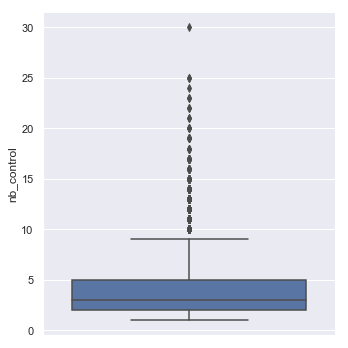

In [17]:
# import matplotlib et seaborn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set() # pour modifier le thème

sns.catplot(y="nb_control" , data=bc_2019_test, kind = 'box');

In [18]:
bc_2019_1 = bc_2019_test[bc_2019_test['nb_control'] < 7]
bc_2019_1.shape

(5609, 36)

In [19]:
bc_2019_1 = bc_2019_1.drop(['Date', 'Num_Train', 'Direction_Ligne', 'Year', 'Month', '15zaine_jour', 
                        'Ligne_Presence_imposee', 'Montant_operation', 'Type_operation_CC BORD', 'Type_operation_CC CONTROLE',
                        'Type_operation_CC GUICHET', 'Type_operation_PV', 'cv', 'nb_controleurs', 'Date_1', 
                         'diff_ctrl_1', 'diff_ctrl_2', 'Date_2', 'diff_ctrl_3', 'Date_3', 'Heure_Origine_2', 'Heure_Fin_2',
                                    ],
                      axis = 1)

bc_2019_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5609 entries, 23 to 159838
Data columns (total 14 columns):
Sous_Ligne          5609 non-null object
Gare_Origine        5609 non-null object
Gare_Fin            5609 non-null object
jour_semaine        5609 non-null int64
Sens_circulation    5609 non-null int64
nb_control          5609 non-null int64
h_x                 5609 non-null float64
h_y                 5609 non-null float64
m_x                 5609 non-null float64
m_y                 5609 non-null float64
nb_control_1        5609 non-null int64
nb_control_2        5609 non-null int64
nb_control_3        5609 non-null int64
temps_trajet        5609 non-null int64
dtypes: float64(4), int64(7), object(3)
memory usage: 657.3+ KB


In [20]:
bc_2019_1 = bc_2019_1.join(pd.get_dummies(bc_2019_1.Sous_Ligne, prefix='S_Ligne'))
bc_2019_1 = bc_2019_1.join(pd.get_dummies(bc_2019_1.jour_semaine, prefix='jr_semaine'))
bc_2019_1 = bc_2019_1.join(pd.get_dummies(bc_2019_1.Gare_Origine, prefix='Gare_Origine'))
bc_2019_1 = bc_2019_1.join(pd.get_dummies(bc_2019_1.Gare_Fin, prefix='Gare_Fin'))

bc_2019_1 = bc_2019_1.drop(['Sous_Ligne', 'jour_semaine', 'Gare_Origine', 'Gare_Fin'], axis = 1)

In [21]:
from sklearn.model_selection import train_test_split

data = bc_2019_1.drop('nb_control', axis = 1)
target = bc_2019_1.nb_control
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)

In [22]:
from sklearn import ensemble

clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)
clf.fit(X_train, y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=321, verbose=0, warm_start=False)

In [23]:
y_pred = clf.predict(X_test)
pd.crosstab(y_test, y_pred, rownames = ['classe réelles'], colnames = ['classe prédite'])

classe prédite,1,2,3,4,5,6
classe réelles,,,,,,
1,123,80,50,20,9,6
2,113,86,43,15,8,8
3,85,69,27,18,10,9
4,43,54,21,21,15,8
5,48,32,18,12,6,6
6,10,12,11,17,5,4


In [24]:
from sklearn.metrics import classification_report

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.29      0.43      0.35       288
           2       0.26      0.32      0.28       273
           3       0.16      0.12      0.14       218
           4       0.20      0.13      0.16       162
           5       0.11      0.05      0.07       122
           6       0.10      0.07      0.08        59

   micro avg       0.24      0.24      0.24      1122
   macro avg       0.19      0.19      0.18      1122
weighted avg       0.22      0.24      0.22      1122



In [27]:
import xgboost as xgb

In [30]:
features_matrix = bc_2019_1.drop('nb_control', axis = 1)
target = bc_2019_1.nb_control

In [31]:
X, X_valid, y, y_valid = train_test_split(features_matrix, target, test_size = 0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [32]:
train = xgb.DMatrix(data = X_train, label= y_train)
test =  xgb.DMatrix(data = X_test, label = y_test)
valid = xgb.DMatrix(data = X_valid, label = y_valid)

In [40]:
params = {'booster' : 'gbtree', 'learning_rate' : 0.01, 'objective' : 'reg:linear'}
xgb1 = xgb.train(params = params,
                dtrain = train, 
                num_boost_round= 100,
                evals= [(train, 'train'), (test, 'eval')])

[18:07:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.67384	eval-rmse:2.74093
[1]	train-rmse:2.65482	eval-rmse:2.72203
[2]	train-rmse:2.63607	eval-rmse:2.70339
[3]	train-rmse:2.61756	eval-rmse:2.68486
[4]	train-rmse:2.59927	eval-rmse:2.66662
[5]	train-rmse:2.58122	eval-rmse:2.64850
[6]	train-rmse:2.56326	eval-rmse:2.63056
[7]	train-rmse:2.54561	eval-rmse:2.61299
[8]	train-rmse:2.52810	eval-rmse:2.59553
[9]	train-rmse:2.51089	eval-rmse:2.57837
[10]	train-rmse:2.49376	eval-rmse:2.56152
[11]	train-rmse:2.47697	eval-rmse:2.54502
[12]	train-rmse:2.46034	eval-rmse:2.52843
[13]	train-rmse:2.44400	eval-rmse:2.51212
[14]	train-rmse:2.42774	eval-rmse:2.49612
[15]	train-rmse:2.41181	eval-rmse:2.48025
[16]	train-rmse:2.39605	eval-rmse:2.46472
[17]	train-rmse:2.38054	eval-rmse:2.44927
[18]	train-rmse:2.36510	eval-rmse:2.43417
[19]	train-rmse:2.34994	eval-rmse:2

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

Racine de l'erreur quadratique (train) : 1.6163916728009395
Racine de l'erreur quadratique (test) : 1.7098709301502175
Erreur absolue (train) : 1.1136536433116662
Erreur absolue (test) : 1.1477779936416435


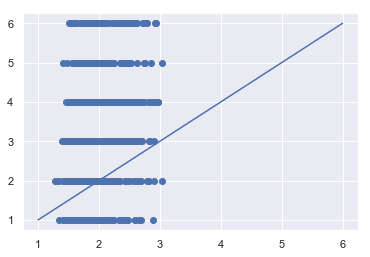

In [49]:
pred_train = xgb1.predict(train)
pred_test = xgb1.predict(test)
print("Racine de l'erreur quadratique (train) :", np.sqrt(mean_squared_error(pred_train, y_train)))
print("Racine de l'erreur quadratique (test) :", np.sqrt(mean_squared_error(pred_test, y_test)))

print("Erreur absolue (train) :", np.sqrt(mean_absolute_error(pred_train, y_train)))
print("Erreur absolue (test) :", np.sqrt(mean_absolute_error(pred_test, y_test)))

plt.scatter(pred_test, y_test)
plt.plot((y_test.min(),y_test.max()), (y_test.min(),y_test.max()));

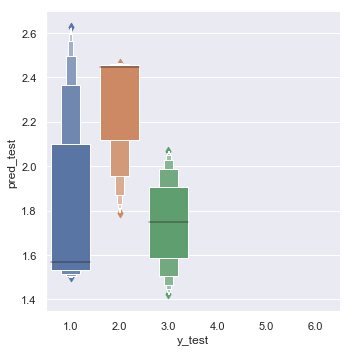

In [50]:
pred_test_2 = pd.DataFrame(pred_test)
pred_test_2.columns = ["pred_test"]
y_test_2 = pd.DataFrame(y_test)
y_test_2.columns = ["y_test"]
result_test = pd.concat([pred_test_2,y_test_2],axis=1)
sns.catplot(x = "y_test", y = "pred_test", kind="boxen", data = result_test);

In [53]:
params = {'booster' : 'gbtree', 'learning_rate' : 0.01, 'objective' : 'multi:softmax', 'num_class' : 7}
xgb1 = xgb.train(params = params,
                dtrain = train, 
                num_boost_round= 100,
                evals= [(train, 'train'), (test, 'eval')])

[18:20:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:1.94134	eval-mlogloss:1.94311
[1]	train-mlogloss:1.93687	eval-mlogloss:1.94036
[2]	train-mlogloss:1.93243	eval-mlogloss:1.93760
[3]	train-mlogloss:1.92806	eval-mlogloss:1.93491
[4]	train-mlogloss:1.92373	eval-mlogloss:1.93222
[5]	train-mlogloss:1.91941	eval-mlogloss:1.92957
[6]	train-mlogloss:1.91518	eval-mlogloss:1.92699
[7]	train-mlogloss:1.91095	eval-mlogloss:1.92440
[8]	train-mlogloss:1.90675	eval-mlogloss:1.92185
[9]	train-mlogloss:1.90267	eval-mlogloss:1.91924
[10]	train-mlogloss:1.89857	eval-mlogloss:1.91684
[11]	train-mlogloss:1.89457	eval-mlogloss:1.91436
[12]	train-mlogloss:1.89060	eval-mlogloss:1.91190
[13]	train-mlogloss:1.88657	eval-mlogloss:1.90951


Racine de l'erreur quadratique (train) : 1.7406084229431966
Racine de l'erreur quadratique (test) : 2.0365472625193966
Erreur absolue (train) : 1.0554230341809594
Erreur absolue (test) : 1.2336053575669255


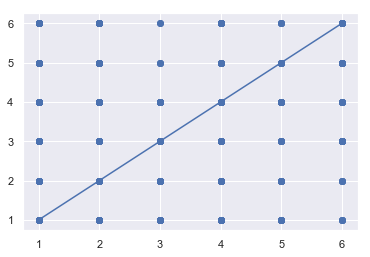

In [54]:
pred_train = xgb1.predict(train)
pred_test = xgb1.predict(test)
print("Racine de l'erreur quadratique (train) :", np.sqrt(mean_squared_error(pred_train, y_train)))
print("Racine de l'erreur quadratique (test) :", np.sqrt(mean_squared_error(pred_test, y_test)))

print("Erreur absolue (train) :", np.sqrt(mean_absolute_error(pred_train, y_train)))
print("Erreur absolue (test) :", np.sqrt(mean_absolute_error(pred_test, y_test)))

plt.scatter(pred_test, y_test)
plt.plot((y_test.min(),y_test.max()), (y_test.min(),y_test.max()));

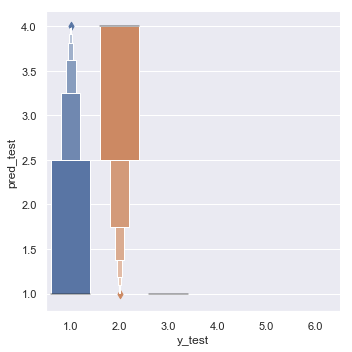

In [55]:
pred_test_2 = pd.DataFrame(pred_test)
pred_test_2.columns = ["pred_test"]
y_test_2 = pd.DataFrame(y_test)
y_test_2.columns = ["y_test"]
result_test = pd.concat([pred_test_2,y_test_2],axis=1)
sns.catplot(x = "y_test", y = "pred_test", kind="boxen", data = result_test);